<a href="https://colab.research.google.com/github/LudwigMeder/Time-Series-Prediction-of-the-NAO/blob/tanja_dev/NHits_first_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# N-Hits

In [1]:
!pip install pytorch-forecasting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install cpflows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for cpflows: filename=cpflows-0.1.2-py3-none-any.whl size=54295 sha256=95fbb6d23fed952e2677a2a45a0c78f257cb2dff6ab4594b8dc199fe7f6ea168
  Stored in directory: /root/.cache/pip/wheels/1b/c3/fd/cdcca84615eb336ec3d17d9d1fd858684240e91b47cf3dab6e
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6488 sha256=398326cc93e4d2f6eb0522e50ac71124bc6975cb8946fd0d0808e7417a807f30
  Stored in directory: /root/.cache/pip/wheels/64/19/61/d440ccd46a2a014bce61fc5c6c8495dedd32ef04cba8b34b28
Successfully built cpflows subprocess32


In [323]:
import numpy as np
import pandas as pd
from pytorch_forecasting import TimeSeriesDataSet, NaNLabelEncoder, Baseline, DeepAR
from pytorch_lightning import Trainer
from pytorch_forecasting.models import NHiTS


import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import torch

from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MQF2DistributionLoss, QuantileLoss, MultivariateNormalDistributionLoss

In [237]:
csv_url = "https://raw.githubusercontent.com/LudwigMeder/Time-Series-Prediction-of-the-NAO/main/1_DatasetCharacteristics/NAO_INDEX_MONTHLY.csv"

NAO_df = pd.read_csv(csv_url)

In [238]:
NAO_df['Date'] = pd.to_datetime(NAO_df['Date'], format='%Y-%m-%d')
NAO_df.reset_index(inplace=True)
NAO_df.rename(columns={'index': 'index_column'}, inplace=True)
print(NAO_df)

      index_column       Date  NAO_index
0                0 1825-01-01     -0.226
1                1 1825-02-01      0.211
2                2 1825-03-01      0.327
3                3 1825-04-01     -0.276
4                4 1825-05-01      0.131
...            ...        ...        ...
2383          2383 2023-08-01     -1.754
2384          2384 2023-09-01     -0.653
2385          2385 2023-10-01     -1.229
2386          2386 2023-11-01     -0.427
2387          2387 2023-12-01      0.671

[2388 rows x 3 columns]


In [239]:
NAO_df['constant_group_id'] = "Static"

In [240]:
print(NAO_df)

      index_column       Date  NAO_index constant_group_id
0                0 1825-01-01     -0.226            Static
1                1 1825-02-01      0.211            Static
2                2 1825-03-01      0.327            Static
3                3 1825-04-01     -0.276            Static
4                4 1825-05-01      0.131            Static
...            ...        ...        ...               ...
2383          2383 2023-08-01     -1.754            Static
2384          2384 2023-09-01     -0.653            Static
2385          2385 2023-10-01     -1.229            Static
2386          2386 2023-11-01     -0.427            Static
2387          2387 2023-12-01      0.671            Static

[2388 rows x 4 columns]


In [299]:
# use 12 months to predict 1 next month
max_encoder_length = 60
max_prediction_length = round(0.1 * NAO_df["index_column"].max())
#max_prediction_length= 20
training_cutoff = NAO_df["index_column"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

#total_time_indices = NAO_df['index_column'].nunique()
#training_cutoff_index = int(total_time_indices * 0.8) - 1
#training_cutoff = NAO_df['index_column'].unique()[training_cutoff_index]
print(max_encoder_length)
print(max_prediction_length)

60
239


In [301]:
print(training_cutoff)
print(len(NAO_df[lambda x: x['index_column'] > training_cutoff]))
print(len(NAO_df[lambda x: x['index_column'] <= training_cutoff]))

2148
239
2149


In [278]:
NAO_df = NAO_df.astype(dict(constant_group_id=str))

In [314]:
training = TimeSeriesDataSet(
    NAO_df[: training_cutoff],
    time_idx="index_column",
    allow_missing_timesteps=True,
    target="NAO_index",
    group_ids=["constant_group_id"],
    time_varying_unknown_reals=["NAO_index"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, NAO_df, min_prediction_idx=training.index.time.max()+1)


In [315]:
print(len(training))
print(len(validation))

1850
300


In [309]:
batch_size = 512

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0, drop_last=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0, )


In [310]:
print(len(train_dataloader))
print(len(val_dataloader))

3
1


In [311]:
# calculate baseline absolute error
baseline_predictions = Baseline().predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
SMAPE()(baseline_predictions.output, baseline_predictions.y)

tensor(1.4457)

In [324]:
pl.seed_everything(42)
import pytorch_forecasting as ptf

trainer = pl.Trainer(accelerator="cpu", gradient_clip_val=1e-1)
net = DeepAR.from_dataset(
    training,
    learning_rate=3e-2,
    hidden_size=30,
    rnn_layers=2,
    loss=MultivariateNormalDistributionLoss(rank=30),
    optimizer="Adam",
)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [331]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-5,
    max_lr=1e0,
    early_stop_threshold=100,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

ValueError: Trainer is already configured with a `LearningRateFinder` callback.Please remove it if you want to use the Tuner.

In [332]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=30,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=50,
    enable_checkpointing=True,
)


net = DeepAR.from_dataset(
    training,
    learning_rate=1e-2,
    log_interval=10,
    log_val_interval=1,
    hidden_size=30,
    rnn_layers=2,
    optimizer="Adam",
    loss=MultivariateNormalDistributionLoss(rank=30),
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: 
  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 0     
3 | rnn                    | LSTM                               | 11.4 K
4 | distr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [334]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

In [335]:
predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
MAE()(predictions.output, predictions.y)

tensor(1.5038)

In [336]:
raw_predictions = best_model.predict(val_dataloader, mode="raw", return_x=True, n_samples=100, trainer_kwargs=dict(accelerator="cpu"))

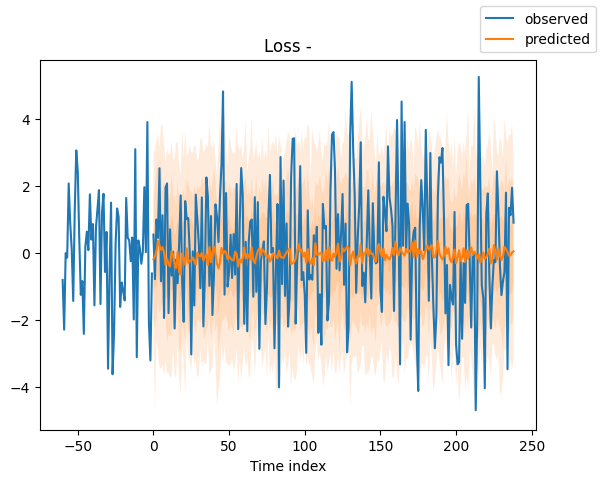

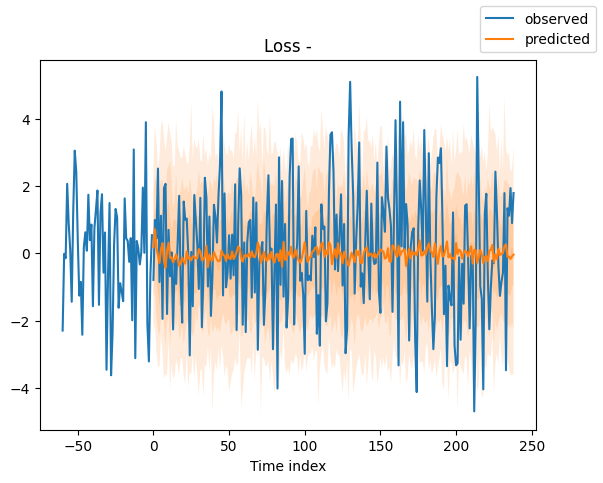

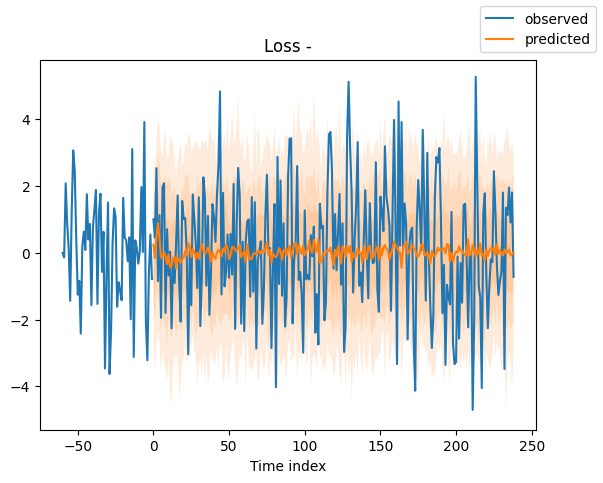

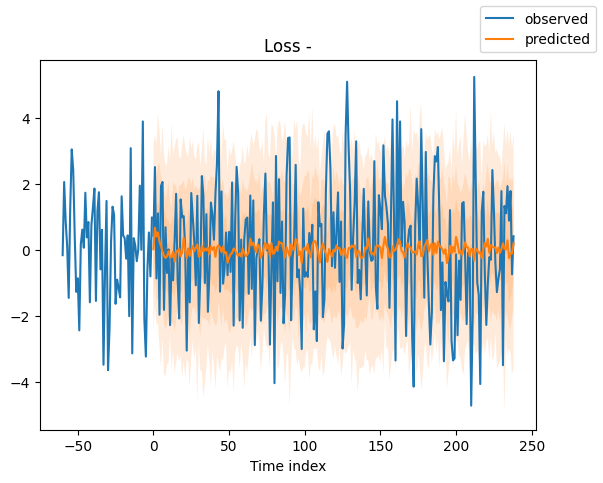

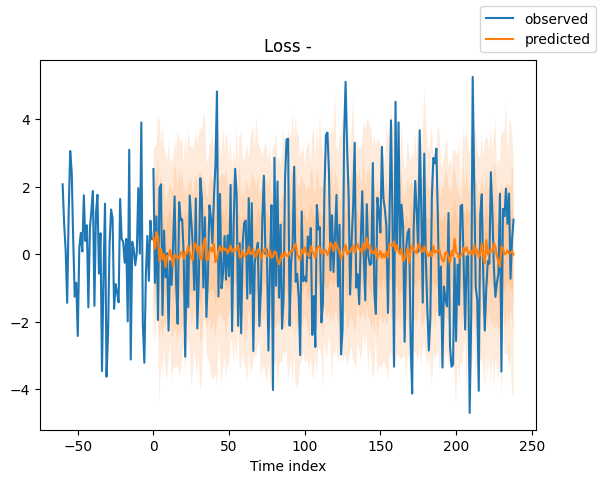

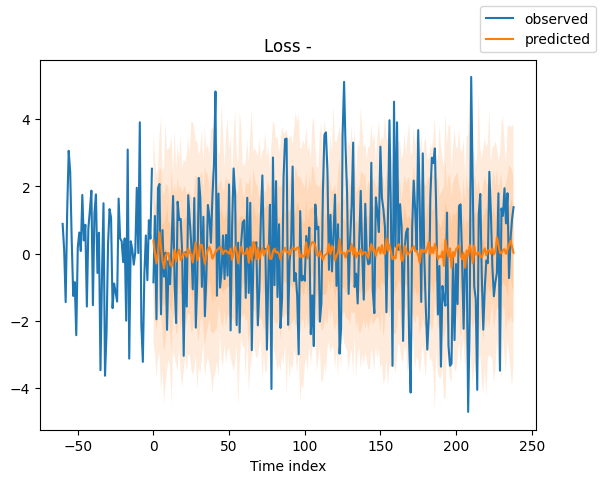

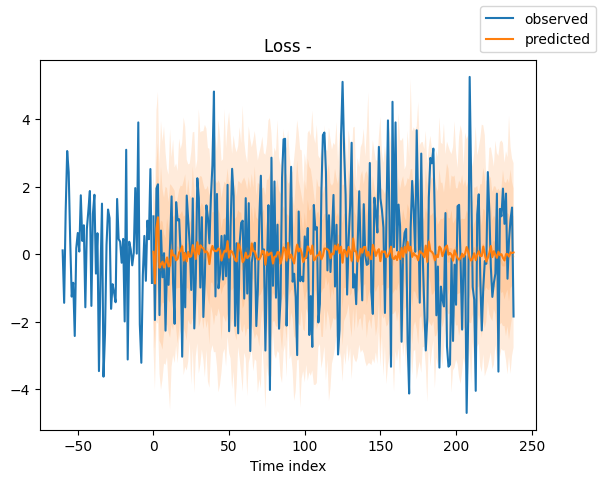

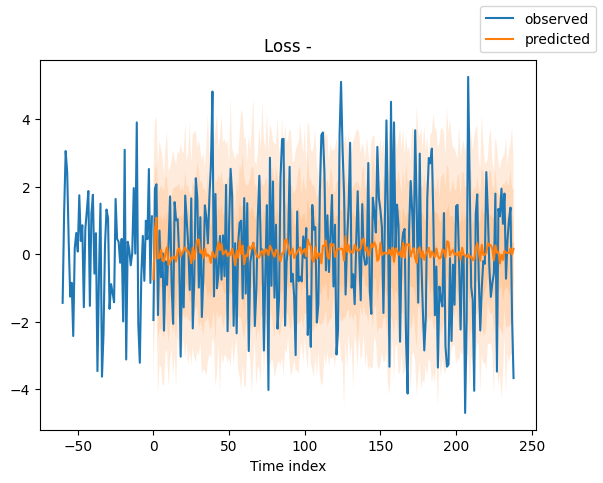

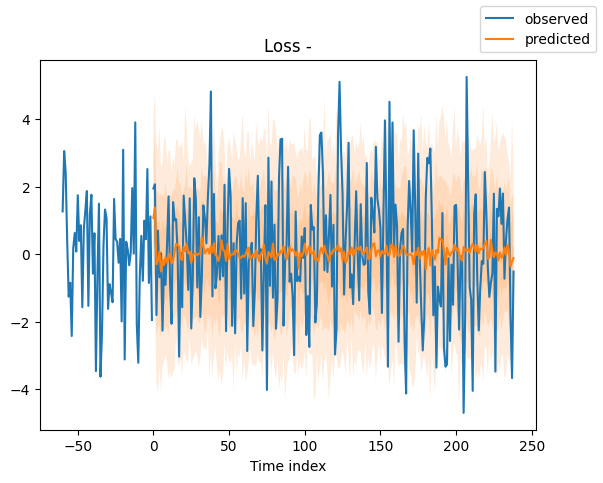

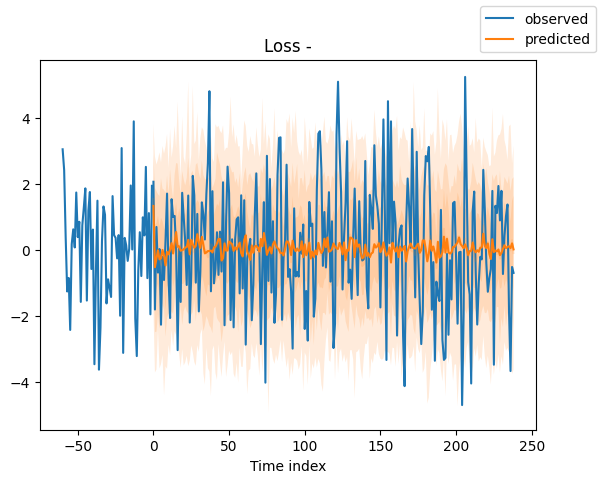

In [337]:
for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)